# Fairness of giving loan credits

The problem of accurately predicting if a loan is paid back by an individual is well studied in ML literature, in the recent days we have observed a trend of investigating in greater detail unwanted consquences of automated decision making.

There various angles and names to such undesired consquences and one of them is a bias. A way to measure if a decision made by a mode is biased is to indroduce a fairness test.

A fairness test is a user specified metric between two groups to make sure there is no significant gap between them, according to these metric.

We will discuss three most popular metric as well as the general ML flow together with the common pitfalls and +/- of the approaches.

In [49]:
import os
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import json
import interpret
pd.set_option('mode.chained_assignment', None) # we actually know what we are doing

# Problem definition: giving a credit

A general flow is pretty standard, given a dataset D=(X,y) we need to find a function f such that f(X) ~= y but with a twist that the dataset D is in fact composed of two groups G1 and G2 and there is a fairness constraint c on the groups such that c(f(G1),f(G2)) holds.

# Introduction into the dataset 

Here we analyze the problem of loans and credits given by a bank to its customers

* We provide a direct link to the dataset, so the data is the same and it's repeatable
* We provide all data transofrmations here, for the same reasons
* All mapping and renaming here are pure cosmetics to make the results interprable by humans without extra effort

In [50]:
data_path = "data/german.data"

In [51]:
# if you don't have wget (on a win machine, for example) just download the data manually
# and put into $data_path
def download_data_if_needed(data_path):
    DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
    if not os.path.isfile(data_path):
        import wget
        wget.download(DATASET_URL, "data/")
    else:
        print('data is already in place')

In [52]:
download_data_if_needed(data_path)

data is already in place


In [53]:
names = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']
df = pd.read_csv(data_path, sep=" ", names=names)
df.classification.replace([1,2], ["good","bad"], inplace=True) # 1 = Good, 2 = Bad => in our encoding 1 is good and 0 is bad
# Print number of 'good' credits (should be 700) and 'bad credits (should be 300)
df.classification.value_counts()

good    700
bad     300
Name: classification, dtype: int64

In [54]:
with open("data/german_mapping.json", "r") as mapping_file:
    mapping = json.load(mapping_file)

In [7]:
df.head()

,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,...,property,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker,classification
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,good
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,bad
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,good
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,good
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,bad


In [55]:
df.replace(mapping, inplace=True)

In [56]:
df['is_female'] = df.statussex.apply(lambda x: "female" in x)

In [57]:
X, y = df.drop(columns="classification"), df['classification']

In [58]:
X.shape

(1000, 21)

In [11]:
df.head()

,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,...,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker,classification,is_female
0,... < 0 DM,6,critical account/other credits existing (not a...,radio/television,1169,unknown/ no savings account,>= 7 years,4,male - single,none,...,67,none,own,2,skilled employee/official,1,"yes, registered under the customers name",local worker,good,False
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,radio/television,5951,... < 100 DM,1 <= < 4 years,2,female - divorced/separated/married,none,...,22,none,own,1,skilled employee/official,1,none,local worker,bad,True
2,no checking account,12,critical account/other credits existing (not a...,education,2096,... < 100 DM,4 <= < 7 years,2,male - single,none,...,49,none,own,1,unskilled - resident,2,none,local worker,good,False
3,... < 0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,... < 100 DM,4 <= < 7 years,2,male - single,guarantor,...,45,none,for free,1,skilled employee/official,2,none,local worker,good,False
4,... < 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= < 4 years,3,male - single,none,...,53,none,for free,2,skilled employee/official,2,none,local worker,bad,False


# Cost matrix and uneven decisions

According to the dataset metadata giving a loan to someone who won't pay it back is as bad as not giving five loans to people who would pay them back, this is reflected as a diagonal cost matrix which is modelled here as class weights, that is a standard technique reflected in the sklearn API.

In [12]:
# that's copied from the UCI metadata page for the German credit dataset
"""
        Good        Bad
  ----------------------------
    Good   0        1
  -----------------------
    Bad    5        0


  the rows represent the actual classification and the columns
  the predicted classification.

  It is worse to class a customer as good when they are bad (5),
  than it is to class a customer as bad when they are good (1).
"""
# that's how we model this diagonal cost matrix
class_weight = {"good" : 1, "bad": 5} 

In [13]:
# weighted accuracy: it's an indicator
# usually we measure the mistakes a classifier makes 
# and minimize the errors, here we just scale "goodness" 
# of a classifier adjusted to the range [0,1]
# it's just meant to indicate performance adjusted to the class weights
def weighted_accuracy(y_test, y_pred, class_weight):
    overall_weight = 0
    correct_weight = 0
    for real, predicated in zip(y_test, y_pred):
        if real == "bad":
            overall_weight += class_weight['bad']
            if real == predicated:
                correct_weight += class_weight['bad']
        else:
            overall_weight += class_weight['good']
            if real == predicated:
                correct_weight += class_weight['good']
    return correct_weight/overall_weight

# Predictive modelling 

Here we apply three different models to the dataset: ridge regression, decition trees and catboost.

The dataset is split in the proportions 2:1 for analysis and then trained using class weigths provided. 

For each classifier we analyze the key metrics.

In [14]:
# Create Ridge regression classifier
ridge_clf = RidgeClassifier(class_weight=class_weight, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(X), y, test_size=0.33, random_state=42)
# Train model
ridge_model = ridge_clf.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)
print(classification_report(y_test,y_pred))
print("weighted_accuracy:", weighted_accuracy(y_test, y_pred, class_weight))

              precision    recall  f1-score   support

         bad       0.47      0.85      0.60       101
        good       0.90      0.57      0.70       229

    accuracy                           0.66       330
   macro avg       0.68      0.71      0.65       330
weighted avg       0.77      0.66      0.67       330

weighted_accuracy: 0.7643051771117166


In [15]:
# Create decision regression classifier
dt_clf = DecisionTreeClassifier(class_weight=class_weight, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(X), y, test_size=0.33, random_state=42)
# Train model
dt_model = dt_clf.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
print(classification_report(y_test,y_pred))
print("weighted_accuracy:", weighted_accuracy(y_test, y_pred, class_weight))

              precision    recall  f1-score   support

         bad       0.49      0.54      0.51       101
        good       0.79      0.75      0.77       229

    accuracy                           0.68       330
   macro avg       0.64      0.65      0.64       330
weighted avg       0.70      0.68      0.69       330

weighted_accuracy: 0.6076294277929155


In [16]:
# Create boosting classifier
catboost_clf = CatBoostClassifier(class_weights=class_weight, random_state=42, cat_features = X.select_dtypes(include=['category', object]).columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# Train model
catboost_model = catboost_clf.fit(X_train, y_train, verbose=False)
y_pred = catboost_model.predict(X_test)
print(classification_report(y_test,y_pred))
print("weighted_accuracy:",weighted_accuracy(y_test, y_pred, class_weight))

              precision    recall  f1-score   support

         bad       0.47      0.82      0.60       101
        good       0.88      0.59      0.71       229

    accuracy                           0.66       330
   macro avg       0.68      0.71      0.65       330
weighted avg       0.76      0.66      0.67       330

weighted_accuracy: 0.7493188010899182


# Modelling fairness

We have picked catboost due to two reasons here: adequate performance and direct handling of categorical variables (doing these transformation to and fro distracts from the main dicsussion here)

We start with augmenting the dataset with decisions made and putting original labels (ground truth) together in one Pandas DataFrame.

In [17]:
# forming an overall dataset
df_test = X.copy()
df_test['prediction'] = catboost_model.predict(X)
df_test['true_class'] = y

In [18]:
# just checking that everything in place
df_test.columns

Index(['existingchecking', 'duration', 'credithistory', 'purpose',
       'creditamount', 'savings', 'employmentsince', 'installmentrate',
       'statussex', 'otherdebtors', 'residencesince', 'property', 'age',
       'otherinstallmentplans', 'housing', 'existingcredits', 'job',
       'peopleliable', 'telephone', 'foreignworker', 'is_female', 'prediction',
       'true_class'],
      dtype='object')

# Fairness metrics

We analyze three key metrics, so called group-fairness measures:

* Representation-based: disparate impact (cf. standard in USA and the only implemented group-fairness measure in H2O): loan approval rate across all loans from a group (using all loan applications: y=default and y=did not default, Group = 1)

* Error-based: equal opportunity (relates to inclusive lending, calculated only for loan applications that were paid back: y= no default). The loan approval rate for protected and favored groups should be similar among people who paid back the loan historically

* Conditional demographic disparity: this is the only group-fairness measure that is in line with the European concept of fair from a legal perspective. This one compares, for a specific group (conditioned) the number of positive decisions divided by the total number of positive decisions for all groups, with the number of negative decisions divided by the total number of negative decisions. If the negative proportion is greater than the positive proportion, this means that the disadvantaged group is given more negative outcomes than its proportion in the population. 


In [19]:
def measure_demographic_parity(group1, group2):
    ''' it's a simple wrapper around positive rate computations '''
    return compute_positive_rate(group1), compute_positive_rate(group2)
    
def compute_positive_rate(df):
    ''' direct computationms of Positives/Size'''
    size = len(df)
    positive_decisions = np.sum(df['prediction'] == "good")
    return positive_decisions/size

def compute_true_positive_rate(df):
    ''' TPR is computed by first subsetting to records with ground truth positive labels
        and then computing positive prediction rate '''
    only_paid_back = df[df['true_class'] == "good"]
    return compute_positive_rate(only_paid_back)

def compute_equal_opportunity(group1, group2):
    ''' wrapper for TPR computations'''
    return compute_true_positive_rate(group1), compute_true_positive_rate(group2)

def __compute_label_matching(df, true_label, prediction_label):
    ''' auxilary function for tp, tn, fp, fn computations '''
    return np.sum((df['true_class'] == true_label) & (df['prediction'] == prediction_label))

def generate_tp_tn_fp_fn(df):
    ''' auxilary function to compute the right values for disparity metrics '''
    tp = __compute_label_matching(df, "good", "good")
    tn = __compute_label_matching(df, "bad", "bad")
    fp = __compute_label_matching(df, "bad", "good")
    fn = __compute_label_matching(df, "good", "bad")
    return tp, tn, fp, fn

# unconditional: упрощенная метрика для вариантов без доп атрибутов
# E(f(x=a,R=r)) == E(f(x=b,R=r)) без R=... 
def compute_conditional_disparity(group1, group2):
    ''' direct definition computetion using true positive, etc '''
    tp1, tn1, fp1, fn1 = generate_tp_tn_fp_fn(group1)
    tp2, tn2, fp2, fn2 = generate_tp_tn_fp_fn(group2)
    dda = (tp1 + fp1) / (tp1 + fp1 + tp2 + fp2)
    ddd = (tn1 + fn1) / (tn1 + fn1 + tn2 + fn2)
    return dda, ddd

def generate_report_for_condition(df, condition):
    ''' wrapping computations in place together with a boolean vector as a splitting condition '''
    group1 = df[condition]
    group2 = df[~condition]
    tpr1, tpr2 = compute_equal_opportunity(group1, group2)
    pr1, pr2 = measure_demographic_parity(group1, group2)
    print('demographic parity', pr1, pr2)
    print('factor for demographic parity', pr1/pr2)
    print('equal opportunity for target and complimentary groups', tpr1, tpr2)
    print('factor for opportunity (aka true positive rate)', tpr1/tpr2)
 #   dda, ddd = compute_conditional_disparity(group1, group2)
 #   print(f"Conditional Demographic disparity: dda {dda}, ddd {ddd} -- satisfied? {dda > ddd}") 

## Experiment 1: female vs male test

In [20]:
print('splitting on female/male')
generate_report_for_condition(df_test, df_test['is_female'])
print(5*"=")
print('splitting on male-divorced-sep/the_rest')
generate_report_for_condition(df_test, df_test['statussex'] == 'male - divorced/separated')
print(5*"=")
print('splitting on male-single')
generate_report_for_condition(df_test, df_test['statussex'] == 'male - single')

splitting on female/male
demographic parity 0.42258064516129035 0.508695652173913
factor for demographic parity 0.8307140887786051
equal opportunity for target and complimentary groups 0.6069651741293532 0.6653306613226453
factor for opportunity (aka true positive rate) 0.9122759695498411
Conditional Demographic disparity: dda 0.2717842323651452, ddd 0.34555984555984554 -- satisfied? False
=====
splitting on male-divorced-sep/the_rest
demographic parity 0.38 0.48736842105263156
factor for demographic parity 0.7796976241900648
equal opportunity for target and complimentary groups 0.5666666666666667 0.6522388059701493
factor for opportunity (aka true positive rate) 0.8688024408848207
Conditional Demographic disparity: dda 0.03941908713692946, ddd 0.059845559845559844 -- satisfied? False
=====
splitting on male-single
demographic parity 0.5237226277372263 0.4314159292035398
factor for demographic parity 1.2139621935242375
equal opportunity for target and complimentary groups 0.67910447761

In [21]:
cut_labels = ['18-25', '25-35', '35-45', '45-55', '55-65', '65+'] # WHO defines age groups
cut_bins = [18, 25, 35, 45, 55, 65, 1000]
df_test['age_category'] = pd.cut(df_test['age'], bins=cut_bins, labels=cut_labels)
# Experiment 6: age
print("Age category 18-25")
generate_report_for_condition(df_test, df_test['age_category'] == '18-25')
print("Age category 65+")
generate_report_for_condition(df_test, df_test['age_category'] == '65+')

Age category 18-25
demographic parity 0.2578947368421053 0.5345679012345679
factor for demographic parity 0.4824358818524372
equal opportunity for target and complimentary groups 0.42727272727272725 0.6898305084745763
factor for opportunity (aka true positive rate) 0.6193879830243466
Conditional Demographic disparity: dda 0.1016597510373444, ddd 0.2722007722007722 -- satisfied? False
Age category 65+
demographic parity 0.6111111111111112 0.47963340122199594
factor for demographic parity 1.2741212550129748
equal opportunity for target and complimentary groups 0.6923076923076923 0.6477438136826783
factor for opportunity (aka true positive rate) 1.0687986171132238
Conditional Demographic disparity: dda 0.022821576763485476, ddd 0.013513513513513514 -- satisfied? True


# Fixing model unfairness

We demonstrate a simple approach that involves shifting one of the classification parameters to adjust for fairness with regard to that group

First, we start with the default probability parameter of 0.5

Second, we shift it for the target group by a small step value 

Third, we check if the fairness test is passed

Finally, if it's, we stop the calculations, otherwise, we go to step 2.

In [22]:
def adjust_predictions(df, threshold):
    df['prediction'] = df['prob'].apply(lambda x: "good" if x >= threshold else "bad")

def find_trehshold(group1, group2):
    threshold = 0.5
    while True:
        dda, ddd = compute_conditional_disparity(group1, group2)
        if dda >= ddd:
            break
        else:
            threshold -= 0.01
            adjust_predictions(group1, threshold)
    return group1, threshold

Applying the approach to the "male vs female" experimental setting

In [23]:
df_prob = df_test.copy() 
df_prob['prob'] = catboost_model.predict_proba(X)[:,0]

df_female = df_prob[df_prob['is_female']]
df_male = df_prob[~df_prob['is_female']]
df_female, threshold = find_trehshold(df_female, df_male)
print(f"updated threshold for the target group: {threshold}")
compute_conditional_disparity(df_female, df_male)

updated threshold for the target group: 0.41999999999999993


(0.3104125736738703, 0.3095723014256619)

Visualizing how parameter changes the distribution

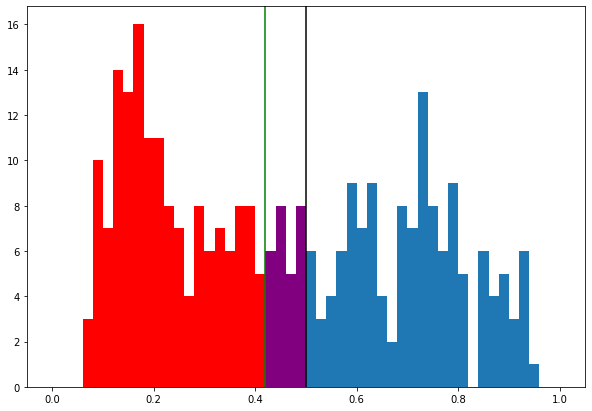

In [24]:
bins = np.arange(0,1.01,0.02)
female_good = df_female[df_female.prob >= 0.5]
female_changed = df_female[(df_female.prob >= threshold) & (df_female.prob < 0.5)]
female_bad = df_female[df_female.prob < 0.5]
plt.figure(figsize=(10,7))
plt.hist(female_good.prob, bins=bins)
plt.hist(female_bad.prob, color="red", bins=bins)
plt.hist(female_changed.prob, color="purple", bins=bins)
plt.axvline(0.5, 0,2, color="black")
plt.axvline(threshold, 0,2, color="green")
plt.show()

521     bad
737    good
740    good
660    good
411    good
       ... 
506    good
342    good
485     bad
711     bad
133    good
Name: classification, Length: 330, dtype: object

In [34]:
from interpret import show
from interpret.perf import ROC
y_test_float = y_test.apply(lambda x: 0 if x == "good" else 1) # we predict probability of a default! so 0 is good :)

blackbox_perf = ROC(catboost_model.predict_proba).explain_perf(X_test, y_test_float, name='Catboost')
show(blackbox_perf)

<!-- http://127.0.0.1:7036/140673092833088/ -->

In [39]:
# USE:
# https://github.com/slundberg/shap
import shap

# load JS visualization code to notebook
shap.initjs()

In [41]:
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [42]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


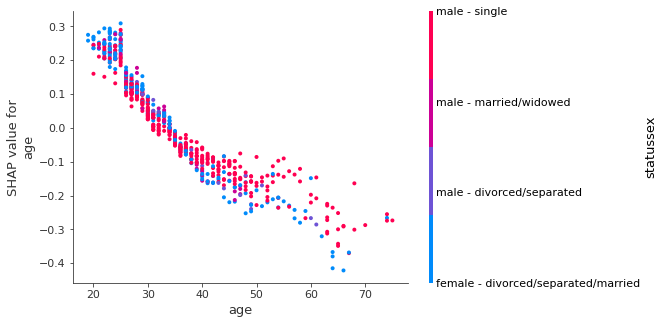

In [43]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("age", shap_values, X_train)

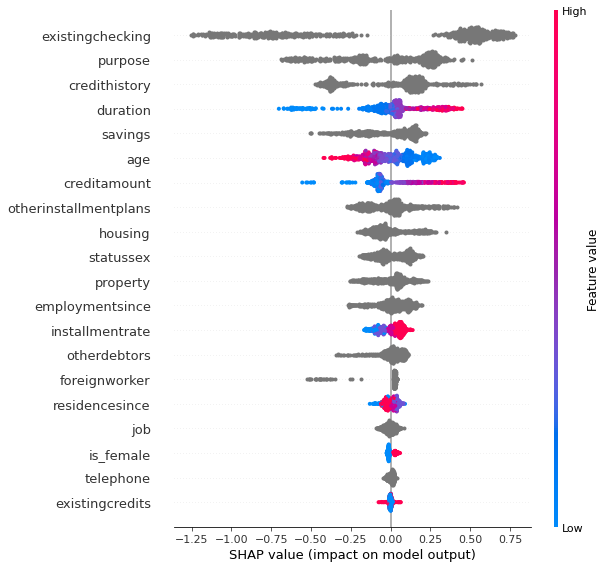

In [47]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

# Ideas to improve here: make categorical features numeric? in the output?

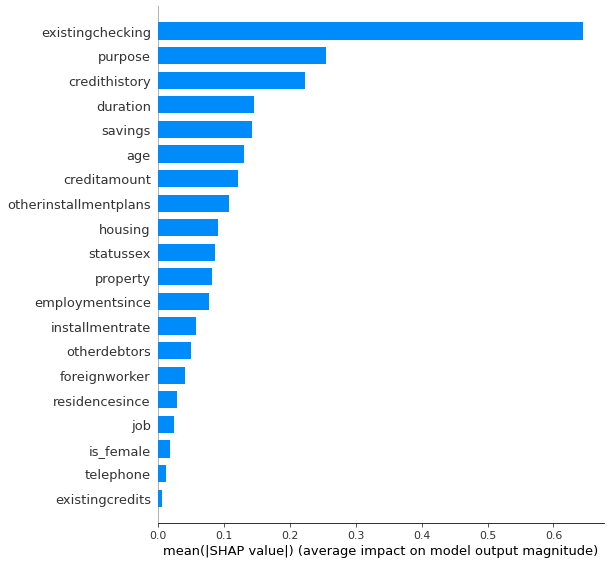

In [48]:
shap.summary_plot(shap_values, X_train, plot_type="bar")